In [74]:
from glob import glob
# import sys
from dotenv import load_dotenv

load_dotenv()
# sys.path.append("/u/zliu/datastor1/KE-by-CP")
import pandas as pd
# from experiments.musique.inference_only import macro_averaging
from knowledge_propagation.utils import io, vars, extractor
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import describe
from thefuzz import fuzz

from datasets import load_dataset, load_from_disk

from copy import deepcopy

from dateutil.parser import parse
from dateutil.parser import ParserError

from collections import defaultdict
import string

import re


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary resources (only needed once)
nltk.download('punkt')
nltk.download('stopwords')

def filter_content_words_nltk(sentence):
    # Tokenize the sentence
    tokens = word_tokenize(sentence)
    
    # Get English stop words
    stop_words = set(stopwords.words('english'))
    
    # Filter out stop words
    content_words = [word for word in tokens if word.lower() not in stop_words and word not in string.punctuation]
    
    return content_words

[nltk_data] Downloading package punkt to /home/zliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
ds = load_dataset("henryzhongsc/MQuAKE-Remastered")
ds.keys()

dict_keys(['CF3k', 'CF9k', 'CF6334', 'T'])

In [155]:
sub_name = "CF3k"
sub_ds = ds[sub_name]

In [156]:
examples = []
count = 0
for i in range(len(sub_ds)):
    example = deepcopy(sub_ds[i])
    # assert len(example["requested_rewrite"]) == 1, len(example["requested_rewrite"])
    edits = []
    for r in example["requested_rewrite"]:
        r["context"] = r["prompt"].format(r["subject"])
        edits.append(r["context"] + " " + r["target_new_str"])
    count += any([example["new_answer"].lower() in e.lower() for e in edits])
    examples.append(example)
    

In [158]:
1858 / 1864

0.9967811158798283

In [154]:
len(examples)

1864

In [48]:
os.makedirs(f"{vars.DATA_DIR}/mquake_remastered/{sub_name}", exist_ok=True)

In [49]:
n_data = len(examples)
n_test = 150
n_dev = 150
n_train = n_data - n_test - n_dev

rand_shuffle = np.arange(n_data)
np.random.shuffle(rand_shuffle)

train_data = [examples[i] for i in rand_shuffle[:n_train]]
dev_data = [examples[i] for i in rand_shuffle[n_train:n_train+n_dev]]
test_data = [examples[i] for i in rand_shuffle[n_train+n_dev:]]

io.dump_jsonlines(train_data, f"{vars.DATA_DIR}/mquake_remastered/{sub_name}/train.jsonl")
io.dump_jsonlines(dev_data, f"{vars.DATA_DIR}/mquake_remastered/{sub_name}/valid.jsonl")
io.dump_jsonlines(test_data, f"{vars.DATA_DIR}/mquake_remastered/{sub_name}/test.jsonl")

### Get correlation betwen overlaps (between edit and question) and llm_acc

In [107]:
pre_df = pd.read_excel("/data/users/zliu/mend/mquake_exp_output/llama3.2-1B-eos-sft/T/base_n=150_prompt=no_w-gen_wo-icl_ice=False.xlsx")

In [130]:
test_data = io.load_jsonlines(f"{vars.DATA_DIR}/mquake_remastered/T/test.jsonl")
# i = 0
df = pd.read_excel("/data/users/zliu/mend/mquake_exp_output/Llama-3.2-1B-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tuned-params=all/all_result_T.xlsx")

cor_content = []

for i in range(len(test_data)):
    sub_df = df[df["id"] == i]
    pre_sub_df = pre_df[pre_df["id"] == i]
    
    instance = test_data[i]
    edits = [rr["context"] + " " + rr["target_new_str"] for rr in instance["requested_rewrite"]]
    edits_content_words = [[w.lower() for w in filter_content_words_nltk(r)] for r in edits]
    
    for q_i, r in sub_df.iterrows():
        pre_r = pre_sub_df[pre_sub_df["question"] == r["question"]]
        assert len(pre_r) == 1
        
        q_content_words = [w.lower() for w in filter_content_words_nltk(r["question"])]
        
        avg_overlaps = np.mean([len(set(e).intersection(set(q_content_words))) / len(set(e)) for e in edits_content_words])
        cor_content.append({
            "avg_overlaps": avg_overlaps,
            "llm_accuracy": r["llm_accuracy"],
            "question_tag": r["question_tag"],
            "llm_accuracy_improve": r["llm_accuracy"] - pre_r.iloc[0]["llm_accuracy"],
        })
        
cor_df = pd.DataFrame(cor_content)

In [131]:
for tag in cor_df["question_tag"].unique():
    tag_df = cor_df[cor_df["question_tag"] == tag]
    print(tag)
    print(np.corrcoef(tag_df["avg_overlaps"].tolist(), tag_df["llm_accuracy_improve"].tolist()))

efficacy_multi-hop
[[1.         0.17113217]
 [0.17113217 1.        ]]
efficacy_single-hop-changed
[[1.         0.29401859]
 [0.29401859 1.        ]]
efficacy_single-hop-unchanged
[[ 1.        -0.0711261]
 [-0.0711261  1.       ]]


In [132]:
np.corrcoef(cor_df["avg_overlaps"].tolist(), cor_df["llm_accuracy_improve"].tolist())[0, 1]

np.float64(0.6264083326665434)

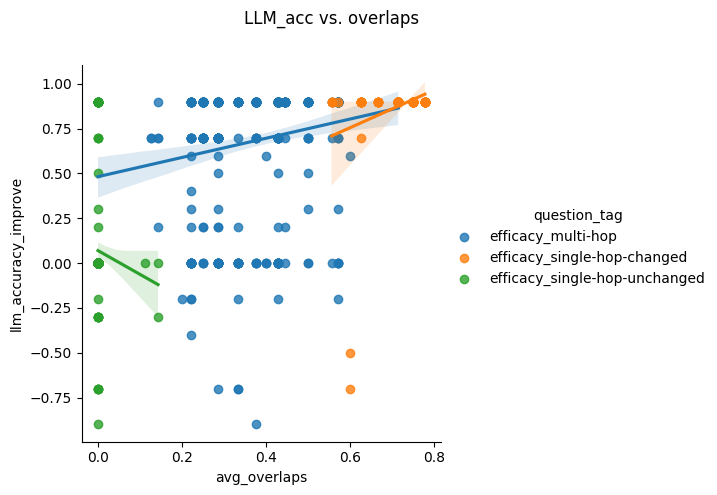

In [133]:
sns.lmplot(
    data=cor_df, 
    x="avg_overlaps", y="llm_accuracy_improve", 
    hue="question_tag",
    order=1,
    facet_kws=dict(sharex=False, sharey=False),
)
plt.suptitle("LLM_acc vs. overlaps")
plt.subplots_adjust(top=0.87)

efficacy_multi-hop
0.1711321653390023
efficacy_single-hop-changed
0.29401859228558747
efficacy_single-hop-unchanged
-0.07112610435081089


In [139]:
test_data = io.load_jsonlines(f"{vars.DATA_DIR}/mquake_remastered/T/test.jsonl")

for i in range(len(test_data)):
    instance = test_data[i]
    edits = [rr["context"] + " " + rr["target_new_str"] for rr in instance["requested_rewrite"]]
    
    print("**Edit**:", "\n\n".join(edits))
    test_queries = []
    for q_str in instance["questions"]:
        test_queries.append({"question": q_str, "answer": instance["new_answer"], "question_type": "multi-hop"})

    changed_single_hops = []
    unchanged_single_hops = []
    assert len(instance["new_single_hops"]) == len(instance["single_hops"])
    for sh, nsh in zip(instance["single_hops"], instance["new_single_hops"]):
        if sh["answer"] != nsh["answer"]:
            # if the reasoning step changes, then use the new reasoning step
            changed_single_hops.append({**nsh, "question_type": "single-hop-changed"})
        else:
            unchanged_single_hops.append({**sh, "question_type": "single-hop-unchanged"})
    # assert len(changed_single_hops) > 0
    # assert len(unchanged_single_hops) > 0
    # test_queries.extend(changed_single_hops)
    # test_queries.extend(unchanged_single_hops)
    print("**Single-hop Queries (changed)**:\n" + "\n\n".join([q["question"] + " " + q["answer"] for q in changed_single_hops]))
    print("**Single-hop Queries (unchanged)**:\n" + "\n\n".join([q["question"] + " " + q["answer"] for q in unchanged_single_hops]))
    print("**Multi-hop Queries**:\n" + "\n\n".join([q["question"] + " " + q["answer"] for q in test_queries]))
    print("===" * 10)

**Edit**: The name of the current head of the South Korea government is Yoon Suk-yeol
**Single-hop Queries (changed)**:
What is the name of the current head of the South Korea government? Yoon Suk-yeol
**Single-hop Queries (unchanged)**:
What type of music does Kim Junsu play? K-pop

Which country was K-pop created in? South Korea
**Multi-hop Queries**:
What is the name of the leader of the government in the country where the music style associated with Kim Junsu was developed? Yoon Suk-yeol

What is the name of the current head of the government of the country where the type of music played by Kim Junsu was created? Yoon Suk-yeol

Who is the head of the government in the country that created the genre of music played by Kim Junsu? Yoon Suk-yeol
**Edit**: The name of the current head of the Sweden government is Ulf Kristersson
**Single-hop Queries (changed)**:
What is the name of the current head of the Sweden government? Ulf Kristersson
**Single-hop Queries (unchanged)**:
What is the 

In [ ]:
test_queries[0]

{'question': 'What is the name of the leader of the government in the country where the music style associated with Kim Junsu was developed?',
 'answer': 'Yoon Suk-yeol',
 'question_type': 'multi-hop'}

In [78]:


# Example usage
# sentence = "The quick brown fox jumps over the lazy dog"
# content_words = filter_content_words_nltk(sentence)



['name', 'current', 'head', 'South', 'Korea', 'government', 'Yoon', 'Suk-yeol']